In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import os
import copy
import random
import json
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.transforms.functional as FT

from tqdm import tqdm
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from utils.crowd.synthetic_data import generate_random_conf_matrix, generate_dl_conf_matrix, generate_box_parameters, generate_synthetic_data, crowd_labels2df, crowd_labels_df2txt
from models.rpn_generator import RPNGenerator

In [3]:
val_coco = COCO('../.data/MSCOCO/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


In [4]:
val_coco.imgToAnns[397133][0]

{'segmentation': [[224.24,
   297.18,
   228.29,
   297.18,
   234.91,
   298.29,
   243.0,
   297.55,
   249.25,
   296.45,
   252.19,
   294.98,
   256.61,
   292.4,
   254.4,
   264.08,
   251.83,
   262.61,
   241.53,
   260.04,
   235.27,
   259.67,
   230.49,
   259.67,
   233.44,
   255.25,
   237.48,
   250.47,
   237.85,
   243.85,
   237.11,
   240.54,
   234.17,
   242.01,
   228.65,
   249.37,
   224.24,
   255.62,
   220.93,
   262.61,
   218.36,
   267.39,
   217.62,
   268.5,
   218.72,
   295.71,
   225.34,
   297.55]],
 'area': 1481.3806499999994,
 'iscrowd': 0,
 'image_id': 397133,
 'bbox': [217.62, 240.54, 38.99, 57.75],
 'category_id': 44,
 'id': 82445}

In [5]:
[(x['bbox'], x['category_id']) for x in val_coco.imgToAnns[397133]]

[([217.62, 240.54, 38.99, 57.75], 44),
 ([1.0, 240.24, 346.63, 186.76], 67),
 ([388.66, 69.92, 109.41, 277.62], 1),
 ([135.57, 249.43, 22.32, 28.79], 49),
 ([31.28, 344.0, 68.12, 40.83], 51),
 ([59.63, 287.36, 76.07, 41.3], 51),
 ([1.36, 164.33, 192.56, 98.37], 79),
 ([0.0, 262.81, 62.16, 36.77], 1),
 ([119.4, 272.51, 24.82, 34.25], 47),
 ([141.47, 267.91, 32.19, 35.86], 47),
 ([155.97, 168.95, 26.03, 17.13], 51),
 ([157.2, 114.15, 17.86, 15.82], 51),
 ([98.75, 304.78, 10.78, 5.57], 56),
 ([166.03, 256.36, 8.82, 18.58], 50),
 ([86.41, 293.97, 23.96, 11.18], 56),
 ([70.14, 296.16, 9.28, 4.58], 56),
 ([0.0, 210.9, 191.36, 98.98], 79),
 ([96.69, 297.09, 7.84, 4.86], 57),
 ([497.25, 203.4, 122.01, 28.61], 81)]

In [6]:
class COCODataset():
    def __init__(self, ann_file, img_dir='../.data/MSCOCO/images'):
        self.coco = COCO(ann_file)
        self.classes = ['background']
        self.superclasses = ['background']
        for i in range(1, max(self.coco.cats.keys()) + 1):
            if i not in self.coco.cats:
                continue
            self.classes.append(self.coco.cats[i]['name'])
            self.superclasses.append(self.coco.cats[i]['supercategory'])
        self.images, self.gt = [], []
        for img_id, img_dict in self.coco.imgs.items():
            self.images.append(os.path.join(img_dir, img_dict['file_name']))
            final_anns = []
            for ann in self.coco.imgToAnns[img_id]:
                if ann['bbox'][2] <= 1 or ann['bbox'][3] <= 1:
                    continue
                if 'iscrowd' in ann:
                    if ann['iscrowd'] == 1:
                        continue
                final_anns.append(self.xywh2xyxy(ann['bbox']) + [self.classes.index(self.coco.cats[ann['category_id']]['name'])])
            if len(final_anns):
                self.gt.append(np.asarray(final_anns).astype(int).tolist())
            else:
                self.gt.append(np.zeros((0, 5), dtype=int))
        
    def xywh2xyxy(self, x):
        y = copy.deepcopy(x)
        y[2] = x[0] + x[2]
        y[3] = x[1] + x[3]
        return y
    
    def get_gt(self, index: int):        
        return self.gt[index]
    
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB") 
        return img, self.get_gt(index)
    
    def __len__(self):
        return len(self.images)

In [7]:
train_dataset = COCODataset('../.data/MSCOCO/annotations/instances_train2017.json')
test_dataset = COCODataset('../.data/MSCOCO/annotations/instances_val2017.json')

loading annotations into memory...
Done (t=12.12s)
creating index...
index created!
loading annotations into memory...
Done (t=2.22s)
creating index...
index created!


In [660]:
# generate typical annotations
crowd_labels, conf_matrix, box_params = generate_synthetic_data(train_dataset, pixel_offset=0, n_annotator=3, annotator_acc_mean=0.5, fixed_box=False, fp_prob=0,
                                                                translation_err_mean=(0.15, 0.15), translation_err_std=(0.1, 0.1), 
                                                                scale_err_mean=(0.3, 0.3), scale_err_std=(0.1, 0.1), seed=12345)

In [36]:
import cv2
import matplotlib.pyplot as plt
import bbox_visualizer as bbv

#monkey patching
def add_label(img,
              label,
              bbox,
              size=1,
              thickness=2,
              draw_bg=True,
              text_bg_color=(255, 255, 255),
              text_color=(0, 0, 0),
              top=True, auto=True):
    """adds label, inside or outside the rectangle

    Parameters
    ----------
    img : ndarray
        the image on which the label is to be written, preferably the image with the rectangular bounding box drawn
    label : str
        the text (label) to be written
    bbox : list
        a list containing x_min, y_min, x_max and y_max of the rectangle positions
    size : int, optional
        size of the label, by default 1
    thickness : int, optional
        thickness of the label, by default 2
    draw_bg : bool, optional
        if True, draws the background of the text, else just the text is written, by default True
    text_bg_color : tuple, optional
        the background color of the label that is filled, by default (255, 255, 255)
    text_color : tuple, optional
        color of the text (label) to be written, by default (0, 0, 0)
    top : bool, optional
        if True, writes the label on top of the bounding box, else inside, by default True

    Returns
    -------
    ndarray
        the image with the label written
    """
    font = cv2.FONT_HERSHEY_SIMPLEX

    (label_width, label_height), baseline = cv2.getTextSize(label, font, size, thickness)
    if auto:
        if sum(text_bg_color) / 3  < 90:
            text_color = (255, 255, 255)
    
    if top:
        label_bg = [bbox[0], bbox[1], bbox[0] + label_width, bbox[1] - label_height - int(9 * size)]
        if draw_bg:
            cv2.rectangle(img, (label_bg[0], label_bg[1]),
                          (label_bg[2] + 5, label_bg[3]), text_bg_color, -1)

        cv2.putText(img, label, (bbox[0] + 5, bbox[1] - int(9 * size)), font, size, text_color, thickness)
    else:
        label_bg = [bbox[0], bbox[1], bbox[0] + label_width, bbox[1] + label_height + int(15 * size)]
        if draw_bg:
            cv2.rectangle(img, (label_bg[0], label_bg[1]),
                          (label_bg[2] + 5, label_bg[3]), text_bg_color, -1)
        cv2.putText(img, label, (bbox[0] + 5, bbox[1] + int(16 * size) + (4 * thickness)), font, size, text_color, thickness)
    return img
def add_multiple_labels(img,
                        labels,
                        bboxes,
                        size=1,
                        thickness=2,
                        draw_bg=True,
                        text_bg_color=(255, 255, 255),
                        text_color=(0, 0, 0),
                        top=True):
    """add labels, inside or outside the rectangles

    Parameters
    ----------
    img : ndarray
        the image on which the labels are to be written, preferably the image with the rectangular bounding boxes drawn
    labels : list
        a list of string of the texts (labels) to be written
    bboxes : list
        a list of lists, each inner list containing x_min, y_min, x_max and y_max of the rectangle positions
    draw_bg : bool, optional
        if True, draws the background of the texts, else just the texts are written, by default True
    text_bg_color : tuple, optional
        the background color of the labels that are filled, by default (255, 255, 255)
    text_color : tuple, optional
        color of the texts (labels) to be written, by default (0, 0, 0)
    top : bool, optional
        if True, writes the labels on top of the bounding boxes, else inside, by default True

    Returns
    -------
    ndarray
        the image with the labels written
    """
    for label, bbox in zip(labels, bboxes):
        img = add_label(img, label, bbox, size, thickness, draw_bg, text_bg_color, text_color,
                        top)

    return img
bbv.add_label = add_label
bbv.add_multiple_labels = add_multiple_labels

In [519]:
single_item = [idx for idx, ann in enumerate(train_dataset.gt) if len(ann) == 1]
double_item = [idx for idx, ann in enumerate(train_dataset.gt) if len(ann) == 2]
triple_item = [idx for idx, ann in enumerate(train_dataset.gt) if len(ann) == 3]

In [733]:
temp = [idx for idx, ann in enumerate(train_dataset.gt) if len(ann) == 3 and any([x[-1] == 51 for x in ann])]


In [734]:
print(temp)

[419, 1452, 2292, 2334, 5004, 5047, 5940, 5973, 7733, 8746, 8967, 9532, 11328, 11745, 13048, 14837, 14850, 14889, 15165, 15796, 16670, 18476, 20262, 21162, 21993, 23844, 25598, 26532, 26533, 26557, 26571, 28358, 29267, 30986, 31012, 33790, 33817, 36054, 36057, 36559, 37118, 38089, 38129, 38185, 39194, 39209, 40208, 42243, 42258, 42273, 42299, 42315, 43903, 44274, 46317, 46319, 46892, 47402, 48415, 48423, 48605, 49467, 49469, 49471, 50511, 50973, 51407, 51415, 51426, 51431, 52507, 52521, 54463, 55550, 55558, 55564, 59670, 59671, 63688, 63720, 63731, 64788, 65809, 65819, 66791, 67184, 68849, 70932, 71312, 73952, 73953, 75980, 76003, 76010, 76027, 78106, 82165, 82210, 84201, 84233, 86316, 86339, 88336, 88348, 89386, 89394, 90372, 90670, 91378, 91411, 91412, 93481, 94511, 95478, 96497, 96522, 97586, 97646, 98484, 98505, 98506, 99334, 99585, 100704, 102689, 102702, 102707, 102721, 102731, 103638, 104672, 105835, 109920, 111868, 112969, 113944, 115012, 115039, 116001, 118010]


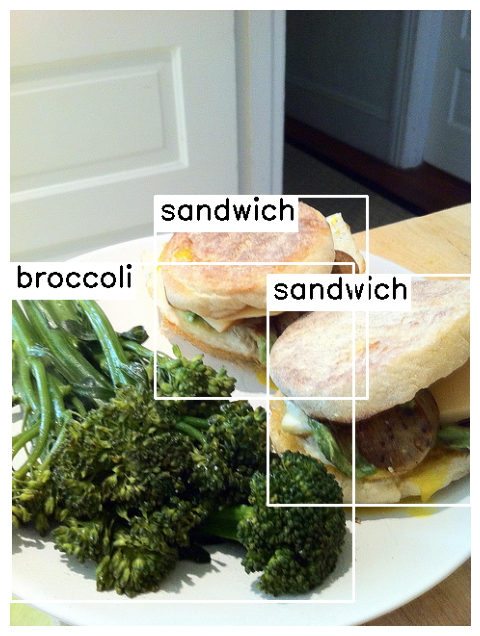

In [786]:
i = 16670
save = True
plt.figure(figsize=(10, 8))
img_path = train_dataset.images[i]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

bboxes = [x[:4] for x in train_dataset.get_gt(i)]
labels = [train_dataset.classes[x[4]] for x in train_dataset.get_gt(i)]
for box, label in zip(bboxes, labels):
    img = bbv.draw_rectangle(img, box, thickness=2)
    img = bbv.add_label(img, label, box, size=1, thickness=2, top=False)

plt.imshow(img)
plt.axis('off')
if save:
    cv2.imwrite(f'./syn_example_gt_{i}.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
# crowd_labels[i]

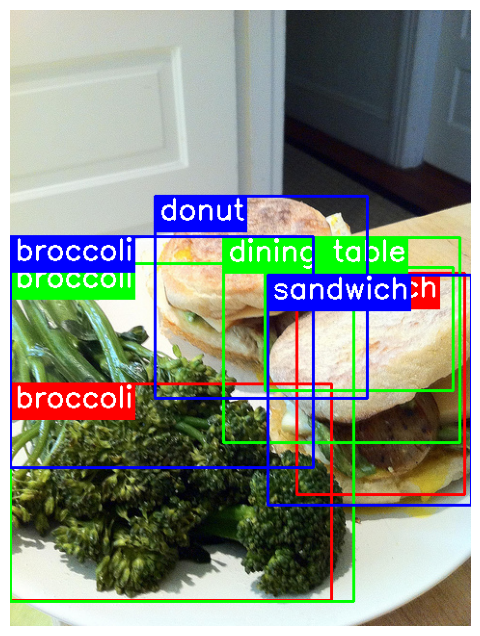

In [787]:
# i = 9
plt.figure(figsize=(10, 8))
# img_path = train_dataset.images[i]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

n = [0,3,2]
ann_dir = '../data/coco_ann10_full/noisy_train'
with open(os.path.join(ann_dir, os.path.basename(img_path) + '.txt'), 'r') as f:
    bbox = np.asarray([list(map(int, x.strip().split(','))) for x in f.readlines()], dtype=np.float32)

# plot some annotators
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255,0,255), (255,255,0), (0, 128, 128), (128,0,128), (128,128,0), (128,128,128)]
# bboxes = [[x[:4] for x in y] for y in crowd_labels[i][:10]]
# labels = [[train_dataset.classes[x[4]] for x in y] for y in crowd_labels[i][:10]]
bboxes = [bbox[bbox[:, 5] == k, :4].astype(int) for k in n]
labels = [[train_dataset.classes[y + 1] for y in bbox[bbox[:, 5] == k, 4].astype(int)] for k in n]

for color, box, label in zip(colors, bboxes, labels):
    img = bbv.draw_multiple_rectangles(img, box, color, thickness=2)
    img = bbv.add_multiple_labels(img, label, box, text_bg_color=color, size=1, thickness=2, top=False)
# for box, label in zip(bboxes, labels):
#     img = bbv.draw_rectangle(img, box, thickness=2)
#     img = bbv.add_label(img, label, box)

# bboxes = [x[:4] for x in train_dataset.get_gt(i)]
# labels = [train_dataset.classes[x[4]] for x in train_dataset.get_gt(i)]
# for box, label in zip(bboxes, labels):
#     img = bbv.draw_rectangle(img, box, thickness=4)
    # img = bbv.add_label(img, label, box)

plt.imshow(img)
plt.axis('off')
if save:
    cv2.imwrite(f'./syn_example_ours_{i}.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

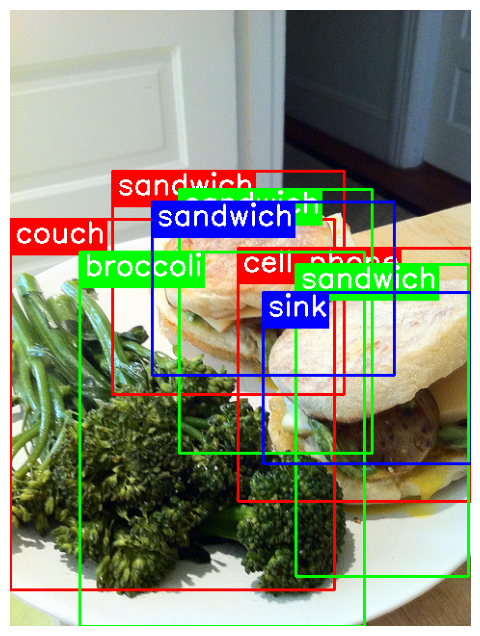

In [788]:
# i = 71
plt.figure(figsize=(10, 8))
img_path = train_dataset.images[i]
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

# plot some annotators
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255,0,255), (255,255,0), (0, 128, 128), (128,0,128), (128,128,0), (128,128,128)]
bboxes = [[x[:4] for x in y] for y in crowd_labels[i][:10]]
labels = [[train_dataset.classes[x[4]] for x in y] for y in crowd_labels[i][:10]]

for color, box, label in zip(colors, bboxes, labels):
    img = bbv.draw_multiple_rectangles(img, box, color, thickness=2)
    img = bbv.add_multiple_labels(img, label, box, text_bg_color=color, size=1, thickness=2, top=False)
# for box, label in zip(bboxes, labels):
#     img = bbv.draw_rectangle(img, box, thickness=2)
#     img = bbv.add_label(img, label, box)

# bboxes = [x[:4] for x in train_dataset.get_gt(i)]
# labels = [train_dataset.classes[x[4]] for x in train_dataset.get_gt(i)]
# for box, label in zip(bboxes, labels):
#     img = bbv.draw_rectangle(img, box, thickness=2)
#     img = bbv.add_label(img, label, box)

plt.imshow(img)
plt.axis('off')
if save:
    cv2.imwrite(f'./syn_example_typ_{i}.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))